<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Explain what the cosine diffuser is
- Define calibration function that includes the cosine receptor uncertainty
- Propagate random and systematic uncertainty with the `punpy` Monte Carlo framework

# Prerequisites

- Understanding of Piccolo spectrometer data processing explained in [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)
- Understanding of random and systematic uncertainty propagation during the radiometric correction process [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)
- Understanding of random and systematic uncertainty propagation during the reflectance computation [case_1-Ex1.2_UPropagation_Noise_Cal.ipynb](case_1-Ex1.2_UPropagation_Noise_Cal.ipynb)
- Understanding of non-lineary response [case_1-Ex2_UPropagation_Noise_Cal](case_1-Ex2_UPropagation_Noise_Cal)

*code from those notebooks is provided below without any explanation, pease refer to the respective notebook if something is unclear*

# TOC

1. [Piccolo data reading](#1)
2. [What does a cosine head do?](#2)
4. [Propagation of uncertainty in radiance (L) and irradiance (E)](#3)
    1. [3-1](#3-1) Radiance (L) [no changes]
    2. [3-2](#3-2) Iradiance (E) [**cos correction**]
6. [Propagation of uncertainty in reflectance (R)](#4)
7. [Export](#5)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 1
## Piccolo data reading

For details on data reading, please, refer to the notebook [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

Reflectance measurements using a spectrometer system (Piccolo doppio)

[back to TOC](#TOC)

In [3]:
data_dir = Path(r'../data/case1-set1')

data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

In [4]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [5]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### Irradiance (E)

In [6]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


#### Integration time correction

In [7]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [8]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

### non-lineary correction

### radiance (L)

In [9]:
C_nonlin_L0 = data['NonLinCoeffsS2_man_L']
C_nonlin_L0_transp = C_nonlin_L0.transpose()
DN_DC_Rad = (DataL0_Rad - Datadark_Rad).mean(axis=1)
CorNonlin_L0 = 1 / np.polyval(C_nonlin_L0_transp, DN_DC_Rad) # correction factor for nonlin

cal_coef_L0_nonlin = data['CcalS2_L_nonlin'] # calibration coeffs from lab cal corrected for nonlin 

array([-2.9567900e-37,  1.8114699e-31, -4.4188601e-26,  5.4452601e-21,
       -3.5208600e-16,  9.8737199e-12,  4.6739501e-08,  9.9326301e-01])

### irradiance (E)

In [11]:
C_nonlin_E0 = data['NonLinCoeffsS2_man_E']
C_nonlin_E0_transp = C_nonlin_E0.transpose()
DN_DC_Irrad = (DataE0_Irrad - Datadark_Irrad).mean(axis=1)
CorNonlin_E0 = 1 / np.polyval(C_nonlin_E0_transp, DN_DC_Irrad) # correction factor for nonlin

cal_coef_E0_nonlin = data ['CcalS2_E_nonlin'] # calibration coeffs from lab cal corrected for nonlin 

array([-2.9567900e-37,  1.8114699e-31, -4.4188601e-26,  5.4452601e-21,
       -3.5208600e-16,  9.8737199e-12,  4.6739501e-08,  9.9326301e-01])

# 2

## What does a cosine head do? (by Gary Llewellyn)

[back to TOC](#TOC)

- The flux of a beam of light at an oblique angle delivers fewer photons per m2 than a beam perpendicular to the surface:


<img src="../images/1-cosine.jpg" alt="cosine"/>


- The ratio of the flux densities of the two beams is the cosine of the angle of the oblique beam
- A sensor should respond to oblique beams with this ratio
- One that does is said to give a cosine response

Naturally, this is only relevant for the upward looking FO, the one that measures irradiance (E)

To account for it we will have to define 
- a different calibration function for E and L
- guestimate $U_S$ component for cosine receptor (we will use 5%)

# 3

## Propagation of uncertainty in radiance (L) and irradiance (E)

[back to TOC](#TOC)

## 3-1
### radiance (L)


[back to TOC](#TOC)

no changes here

In [16]:
prop = punpy.MCPropagation(10000)

In [17]:
## propagation function
def calibrate_nonlin(light_meas, dark_meas, cal_coef_nonlin, nonlin_coef):
    return (light_meas - dark_meas) * cal_coef_nonlin * nonlin_coef

In [18]:
## helper function to derive nonlinearity uncertainty
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

In [19]:
## mean value
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

L1 = calibrate_nonlin(L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0)

## random uncertainty
L0_ur = np.std(L0, axis=1) / (N_L**0.5) 
dark_L0_ur = np.std(dark_L0, axis=1) / (M_L**0.5)

## propagtaion of U_R
L1_ur = prop.propagate_random(calibrate_nonlin,
                              [L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0],
                              [L0_ur, dark_L0_ur, np.zeros(len(Wvl)), np.zeros(len(Wvl))])  

## systematic uncertainty
L0_assumed_us_perc = 3 # in percents
L0_cert_us_rel = np.ones(len(Wvl)) * L0_assumed_us_perc / 100
cCalL_us_abs = L0_cert_us_rel * cal_coef_L0_nonlin  # is the absolute uncertainty of the standard instrument used for calibration

## non-linearity
L1_uncorrected = calibrate(L0_m, dark_L0_m, cal_coef_L0)
L1_nonlin_dev = abs((L1_uncorrected - L1) / L1)

## propagtaion of U_S
L1_us = prop.propagate_systematic(calibrate_nonlin, 
                                  [L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalL_us_abs, L1_nonlin_dev])

L1_ut = (L1_ur ** 2 + L1_us ** 2) ** 0.5 # total uncertainty

## 3-2
### irradiance (E)


[back to TOC](#TOC)

Three changes
1. calibration function that accounts for cosine diffuser effect
2. guestimate of cos head calibration (uniform one)
3. guestimate of 5% uncertainty of this cos head calibration

In [20]:
## propagation function
def calibrate_nonlin_cos(light_meas, dark_meas, cal_coef_nonlin, nonlin_coef, cos_cor):
    return (light_meas - dark_meas) * cal_coef_nonlin * nonlin_coef * cos_cor

In [21]:
CorCos = np.ones(len(Wvl)) # here we consider to be 1

In [22]:
## mean value
E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)


E1 = calibrate_nonlin_cos(E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0, CorCos)

## random uncertainty
E0_ur = np.std(E0, axis=1) / (N_E ** 0.5) 
dark_E0_ur = np.std(dark_E0, axis=1) / (M_E ** 0.5)

## propagtaion of U_R
E1_ur = prop.propagate_random(calibrate_nonlin_cos,
                              [E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0, CorCos],
                              [E0_ur, dark_E0_ur, np.zeros(len(Wvl)), np.zeros(len(Wvl)), np.zeros(len(Wvl))])  


## systematic uncertainty
E0_assumed_us_perc = 3 # in percents
E0_cert_us_rel = np.ones(len(Wvl)) * E0_assumed_us_perc / 100
cCalE_us_abs = E0_cert_us_rel * cal_coef_E0_nonlin  # is the absolute uncertainty of the standard instrument used for calibration

## non-linearity
E1_uncorrected = calibrate(E0_m, dark_E0_m, cal_coef_E0)
E1_nonlin_dev = abs((E1_uncorrected - E1) / E1)

##############################################################################
## cosine effect
E0_cos_assumed_us_perc = 5 # in percents
CorCos_E_us_rel = np.ones(len(Wvl)) * E0_cos_assumed_us_perc / 100 
CorCos_E_us_abs = CorCos_E_us_rel * CorCos
###############################################################################

## propagtaion of U_S
E1_us = prop.propagate_systematic(calibrate_nonlin_cos, 
                                  [E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0, CorCos], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalE_us_abs, E1_nonlin_dev, CorCos_E_us_abs])

E1_ut = (E1_ur ** 2 + E1_us ** 2) ** 0.5 # total uncertainty

## plotting

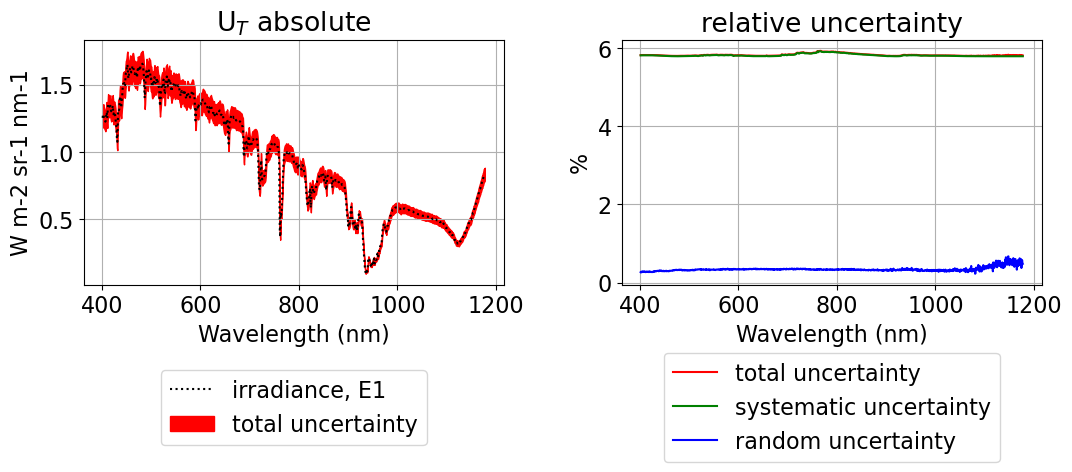

In [31]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = E1
ur = E1_ut
c = 'red'
utype = 'total'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='irradiance, E1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, E1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, E1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty")
ax.set_ylabel('%')
# ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 4
## Propagation of uncertainty in reflectance (R)

[back to TOC](#TOC)

Nothing new here

In [24]:
def deriveR(L, E):
    return  (np.pi * L) / E

In [25]:
R1 = deriveR(L1, E1)

R1_ur = prop.propagate_random(deriveR, 
                              [L1, E1],
                              [L1_ur,E1_ur])

R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) 

R1_ut = (R1_ur ** 2 + R1_us ** 2) ** 0.5 # total uncertainty

In [26]:
R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) 

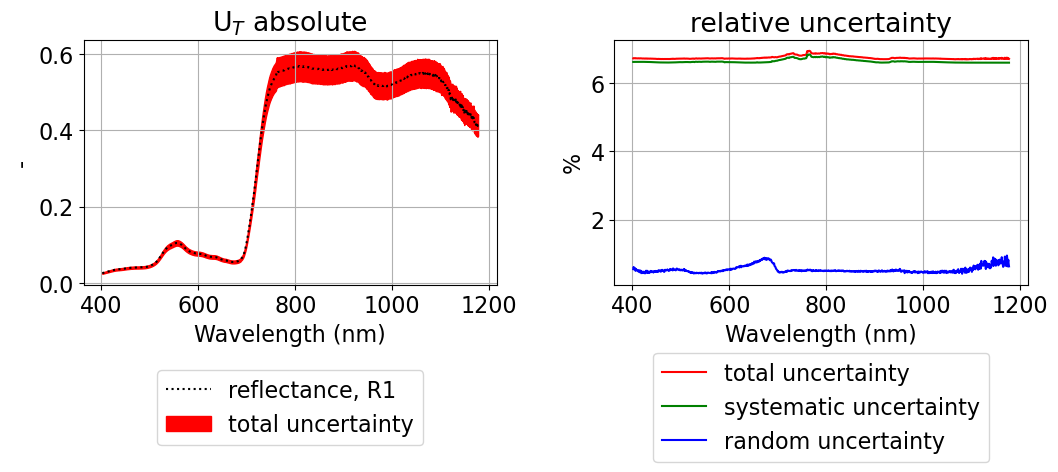

In [32]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = R1
ur = R1_ut
c = 'red'
utype = 'total'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='reflectance, R1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute")
ax.set_ylabel('-')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, R1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, R1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty")
ax.set_ylabel('%')
# ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 5
## Export

Reflectance with its uncertainty are the inputs to the next steps retrieval and biochemical model runs.

Let's save it as a table .csv (dataframe)

[back to TOC](#TOC)

In [28]:
df = pd.DataFrame(
    {'wl': Wvl,
     'refl': R1,
     'refl_u': R1_ut
    }).set_index('wl')

df.head()

,refl,refl_u
wl,,
401.82374,0.026384,0.001772
402.61047,0.026515,0.001783
403.39714,0.026846,0.001804
404.18373,0.027021,0.001816
404.97025,0.027365,0.001840


In [29]:
# df.to_csv('R1_ut_nonlinearity.csv')